In [1]:

from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule, UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver, ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit import Aer, IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram, plot_circuit_layout, plot_gate_map
import pickle

In [6]:
# Save IBM account
IBMQ.save_account('')
IBMQ.load_account()
# Choose the provider (if you have more than one)
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='uminho-1', project='main')

# Show the possible backends
provider.backends()


configrc.store_credentials:WARNING:2023-01-15 08:49:03,953: Credentials already present. Set overwrite=True to overwrite.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-research-2', group='uminho-1', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-research-2', gr

# Quantum Chemistry
## Finding the minimum energy of moleculas
### Class of Quantum Computation of University of Minho
### 2022/2023
#### Maria Gabriela Jordão Oliveira, pg50599
#### Miguel Caçador Peixoto, pg

In [25]:
# Choose the "perfect" simulator
simulation_backend = Aer.get_backend("statevector_simulator")

# Choose the real device
real_device = provider.get_backend('ibm_lagos')

# Create a simulator from the real device
sim_device = AerSimulator.from_backend(real_device)

In [20]:
# Exact solver for comparison
def exact_solver(problem, converter):
    '''
    This function finds the exact solution for a given problem and converter.
    This is a pure classical solver.
    '''
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

# NaH

##### Expected energy: -160.315703 hartree
##### Expected bond length: 1.654 Angstrom

In [78]:
def get_qubit_op(dist):
    '''
    Args:
    dist : Distance between Na and H in Angstrom
    
    Returns:
    qubit_op : Qubit operator
    num_particles : Number of particles
    num_spin_orbitals : Number of spin orbitals
    problem : Problem. Electronic structure problem with driver and transformers. Freeze core transformation is used.
    converter : Converter. Qubit converter with parity mapper and two qubit reduction.
    '''
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Na", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])
                              # remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True )
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [79]:

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -158.80188 Exact Energy: -158.80193
Interatomic Distance: 0.7 VQE Result: -159.52647 Exact Energy: -159.52649
Interatomic Distance: 0.9 VQE Result: -159.92208 Exact Energy: -159.92214
Interatomic Distance: 1.1 VQE Result: -160.15695 Exact Energy: -160.15700
Interatomic Distance: 1.3 VQE Result: -160.27199 Exact Energy: -160.27202
Interatomic Distance: 1.5 VQE Result: -160.31891 Exact Energy: -160.31895
Interatomic Distance: 1.7 VQE Result: -160.32735 Exact Energy: -160.32742
Interatomic Distance: 1.9 VQE Result: -160.31391 Exact Energy: -160.31400
Interatomic Distance: 2.1 VQE Result: -160.28893 Exact Energy: -160.28899
Interatomic Distance: 2.3 VQE Result: -160.25904 Exact Energy: -160.25917
Interatomic Distance: 2.5 VQE Result: -160.22872 Exact Energy: -160.22897
Interatomic Distance: 2.7 VQE Result: -160.20011 Exact Energy: -160.20114
Interatomic Distance: 2.9 VQE Result: -160.17628 Exact Energy: -160.17725
Interatomic Distance: 3.1 VQE Result: 

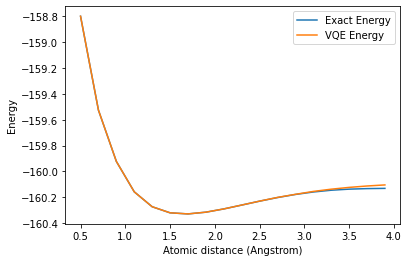

In [80]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [81]:
num_spin_orbitals

10

In [35]:
qubit_op.num_qubits

8

In [36]:
var_form.num_qubits

8

# BeH2
##### Expected energy: -15.561353 hartree
##### Expected bond length: 1.291 Angstrom


In [61]:
def get_qubit_op_be(dist):
    '''
    Args:
    dist : Distance between Be and H in Angstrom
    
    Note -> BeH2 is a linear molecula. So the distance between Be and each H is the same.
    
    Returns:
    qubit_op : Qubit operator
    num_particles : Number of particles
    num_spin_orbitals : Number of spin orbitals
    problem : Problem. Electronic structure problem with driver and transformers. Freeze core transformation is used.
    converter : Converter. Qubit converter with parity mapper and two qubit reduction.
    '''
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Be", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]],
            ["H", [-dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])
                              # remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [63]:

distances = np.arange(0.5, 3.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op_be(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=simulation_backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -13.68766 Exact Energy: -13.68826
Interatomic Distance: 0.7 VQE Result: -14.87056 Exact Energy: -14.87098


KeyboardInterrupt: 

## H2
##### Expected energy: -1.117506  hartree
##### Expected bond length: 0.712 Angstrom

In [9]:
def get_qubit_op_h2(dist):
    '''
    Args:
    dist : Distance between H and H in Angstrom
    
    Returns:
    qubit_op : Qubit operator
    num_particles : Number of particles
    num_spin_orbitals : Number of spin orbitals
    problem : Problem. Electronic structure problem with driver and transformers. Freeze core transformation is used.
    converter : Converter. Qubit converter with parity mapper and two qubit reduction.
    '''
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])
                              # remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [10]:
#backend = Aer.get_backend("statevector_simulator")
distances = np.arange(0.1, 2, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op_h2(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=simulation_backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

# Save the data
with open("simulation_h2.pkl", "wb") as f:
    pickle.dump(vqe_energies, f)
with open("exact_h2.pkl", "wb") as f:
    pickle.dump(exact_energies, f)

Interatomic Distance: 0.1 VQE Result: 2.70996 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 0.15748 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: -0.60180 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.91415 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -1.05516 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -1.11629 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -1.13619 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -1.13415 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -1.12056 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -1.10115 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -1.07919 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -1.05674 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -1.03519 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -1.01547 Exact Energy: -1.01547
Interatomic Distance: 1.

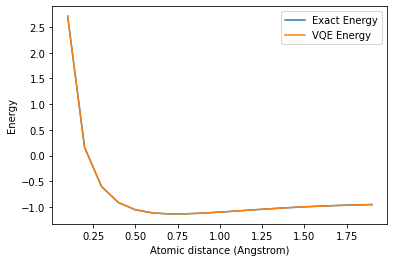

In [11]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [12]:
var_form.num_qubits

2

In [13]:
qubit_op.num_qubits

2

#### Simulador lagos

In [15]:
distances = np.arange(0.1, 2, 0.1)
exact_energies = []
vqe_energies = []
#optimizer = SLSQP(maxiter=100)
#
#Get noise model

coupling_map = sim_device.configuration().coupling_map
qi = QuantumInstance(sim_device,
                    coupling_map=coupling_map,
                    measurement_error_mitigation_cls=CompleteMeasFitter)
# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op_h2(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    optimizer = SPSA(maxiter=100)
    var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
    vqe = VQE(var_form, optimizer=optimizer,quantum_instance=qi)
    vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result[0]:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

# Save the data
with open("noise_simulation_h2.pkl", "wb") as f:
    pickle.dump(vqe_energies, f)

Interatomic Distance: 0.1 VQE Result: 2.77325 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 0.24673 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: -0.57750 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.87046 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -0.99314 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -1.05867 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -1.11937 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -1.09371 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -1.06736 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -1.08090 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -1.05303 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -1.04319 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -0.99345 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -0.99471 Exact Energy: -1.01547
Interatomic Distance: 1.

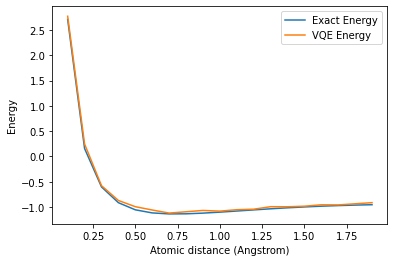

In [16]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [19]:
qubit_op.num_qubits

2

### Computador quantico real

In [19]:
print("Running on: ", real_device)
plot_gate_map(real_device)

Running on:  ibm_lagos


In [26]:
properties = real_device.properties()

properties.to_dict()

{'backend_name': 'ibm_lagos',
 'backend_version': '1.2.1',
 'last_update_date': datetime.datetime(2023, 1, 14, 15, 40, 43, tzinfo=tzlocal()),
 'qubits': [[{'date': datetime.datetime(2023, 1, 14, 14, 50, 24, tzinfo=tzlocal()),
    'name': 'T1',
    'unit': 'us',
    'value': 130.98083750865038},
   {'date': datetime.datetime(2023, 1, 14, 5, 49, 10, tzinfo=tzlocal()),
    'name': 'T2',
    'unit': 'us',
    'value': 44.223363675526144},
   {'date': datetime.datetime(2023, 1, 14, 15, 40, 43, tzinfo=tzlocal()),
    'name': 'frequency',
    'unit': 'GHz',
    'value': 5.235357861207796},
   {'date': datetime.datetime(2023, 1, 14, 15, 40, 43, tzinfo=tzlocal()),
    'name': 'anharmonicity',
    'unit': 'GHz',
    'value': -0.33986713855915607},
   {'date': datetime.datetime(2023, 1, 14, 5, 44, 19, tzinfo=tzlocal()),
    'name': 'readout_error',
    'unit': '',
    'value': 0.011700000000000044},
   {'date': datetime.datetime(2023, 1, 14, 5, 44, 19, tzinfo=tzlocal()),
    'name': 'prob_meas0_p

In [27]:
distances = np.arange(0.1, 1.1, 0.2)
exact_energies = []
vqe_energies = []
#optimizer = SLSQP(maxiter=100)

coupling_map = real_device.configuration().coupling_map
qi = QuantumInstance(real_device,
                    measurement_error_mitigation_cls=CompleteMeasFitter)
# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op_h2(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    optimizer = SPSA(maxiter=20)
    var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
    vqe = VQE(var_form, optimizer=optimizer,quantum_instance=qi)
    vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result[0]:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")
import pickle
with open('real_h2.pkl', 'wb') as f:
    pickle.dump(vqe_energies, f)

# Generic function

In [ ]:
molecule_geometry = lambda dist:[
            ["Na", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ]
multiplicity = 1
charge = 0
remove_orbitals = []
def get_generic_qubit_op( molecule_geometry, multiplicity, charge, basis = None, remove_orbitals=None):
    '''
    Args:
    molecule_geometry : Molecule geometry. List of lists. First element of each list is the atom name, second element is the coordinates.
    multiplicity : Multiplicity. 2*spin + 1
    charge : Charge of the molecule
    basis : Basis set. Default is sto3g
    remove_orbitals : List of orbitals to remove. Default is None. Please unsure that the orbitals are not occupied.
    
    Returns:
    qubit_op : Qubit operator
    num_particles : Number of particles
    num_spin_orbitals : Number of spin orbitals
    problem : Problem. Electronic structure problem with driver and transformers. Freeze core transformation is used.
    converter : Converter. Qubit converter with parity mapper and two qubit reduction.
    '''
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry= molecule_geometry,
        multiplicity= multiplicity,  # = 2*spin + 1
        charge= charge,
    )
    print(molecule_geometry)
    if basis is None:
        basis = "sto3g"
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis= basis,
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True, remove_orbitals=remove_orbitals)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True )
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [ ]:
molecule_geometry = lambda dist:[
            ["H", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ]
multiplicity = 1
charge = 0
remove_orbitals = []

distances = np.arange(0.1, 2, 0.1)
exact_energies = []
vqe_energies = []
#optimizer = SLSQP(maxiter=100)

coupling_map = real_device.configuration().coupling_map
qi = QuantumInstance(real_device,
                    measurement_error_mitigation_cls=CompleteMeasFitter)
# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_generic_qubit_op(molecule_geometry(dist), multiplicity, charge, remove_orbitals=remove_orbitals))
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    optimizer = SPSA(maxiter=100)
    var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
    vqe = VQE(var_form, optimizer=optimizer,quantum_instance=qi)
    vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result[0]:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")
import pickle
with open('real_h2.pkl', 'wb') as f:
    pickle.dump(vqe_energies, f)